In [170]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Training Data Default

In [171]:
players = pd.read_csv("Data/players.csv")
match = pd.read_csv("Data/match.csv")

In [172]:
players

,match_id,account_id,hero_id,player_slot,gold,gold_spent,gold_per_min,xp_per_min,kills,deaths,...,unit_order_glyph,unit_order_eject_item_from_stash,unit_order_cast_rune,unit_order_ping_ability,unit_order_move_to_direction,unit_order_patrol,unit_order_vector_target_position,unit_order_radar,unit_order_set_item_combine_lock,unit_order_continue
0,0,0,86,0,3261,10960,347,362,9,3,...,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN
1,0,1,51,1,2954,17760,494,659,13,3,...,NaN,NaN,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,83,2,110,12195,350,385,0,4,...,NaN,NaN,NaN,17.0,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2,11,3,1179,22505,599,605,8,4,...,1.0,NaN,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN
4,0,3,67,4,3307,23825,613,762,20,3,...,3.0,NaN,NaN,23.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,49999,0,100,128,2718,17735,468,626,16,9,...,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN
499996,49999,0,9,129,3755,20815,507,607,12,6,...,1.0,NaN,NaN,15.0,NaN,NaN,NaN,NaN,NaN,NaN
499997,49999,0,90,130,1059,16225,371,404,5,3,...,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN
499998,49999,0,73,131,3165,31015,780,703,8,6,...,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN


# More Data

In [173]:
early_game = pd.read_csv("All_data_early_game.csv")
hero_id = pd.read_csv("Data/hero_names.csv")
hero_roles = pd.read_csv("Data/hero_roles728a.csv")

# Start Preprocessing Phase

## Form Hero Roles

In [174]:
roles_dict = dict(list(enumerate(['Carries', 'Supports', 'Nukers', 'Disablers', 'Junglers', 'Durable',
       'Escape', 'Pushers', 'Initiators'],start=1)))

In [175]:
roles = []

for i in tqdm(hero_id.localized_name):
    temp_role = []
    for j in range(len(hero_roles.columns)):
        for k in hero_roles[hero_roles.columns[j]]:
            if i==k:
                temp_role.append(hero_roles.columns[j])
    roles.append(temp_role)

100%|██████████████████████████████████████████████████████████████████████████████| 112/112 [00:00<00:00, 7418.74it/s]


In [176]:
hero_id["Roles"] = roles
hero_id.Roles[74] = ['Carries', 'Nukers', 'Disablers']

C:\Users\bimoi\AppData\Local\Temp\ipykernel_12840\2290769231.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hero_id.Roles[74] = ['Carries', 'Nukers', 'Disablers']


## Define Synergy Calculator

In [177]:
Hard_support = ["Supports","Nukers","Disablers"] #100,60,50
Support = ["Supports","Disablers","Initiators","Escape"] #100,70,65,60
Offlane = ["Durable","Initiators","Pushers","Disablers"] #90,80,70,50
Midlaner = ["Carries","Escape","Nukers","Initiators"] #80,80,70,60
Carry = ["Carries","Pushers","Junglers"] #95,60,50

Ideal_Team = Hard_support+Support+Offlane+Midlaner+Carry
Weight_Ideal_Team = [100,60,50,100,70,65,60,90,80,70,50,80,80,70,60,95,60,50]

In [178]:
def find_all_roles(hero_id_list):
    temp_roles = []

    for i in hero_id_list:
        hero_role = hero_id[hero_id.hero_id==i].Roles
#         print(i,hero_role,hero_id[hero_id.hero_id==i].localized_name,"\n")
        if hero_id_list!=21:
            temp_roles = temp_roles+list(hero_role)[0]
        else:
            temp_roles = temp_roles+hero_role
        
    return temp_roles

In [179]:
# pos 5 support, disabler or nuker
# pos 4 support, nuker or disabler or escape
# pos 3 durable, pusher or initiator, can support or carry
# pos 2 nuke or disable, escape, carry
# pos 1 carry

In [180]:
def synergy_cal(hero_role):

    cumsum = 0
    # Manual Weight
    temp_df = pd.DataFrame(hero_role,columns=["Roles"])
    if len(temp_df[temp_df.Roles=="Supports"])!=2:
        cumsum = cumsum-1
    if len(temp_df[temp_df.Roles=="Carries"])!=2:
        cumsum = cumsum-1

    #Automatic Weight
    for i in hero_role:
        for j in range(len(roles_dict)):
            dict_val = j+1
            if i==roles_dict[dict_val]:
                val = dict_val*(Weight_Ideal_Team[j]//(100*dict_val))
                cumsum = cumsum+val
    return cumsum/9

## Filtering and Transforming Players Dataset

In [181]:
match_left = players[players.hero_id<=0].match_id
players = players.copy()
players = players[~players.match_id.isin(match_left)]
players.reset_index(inplace=True)
players.drop(players.columns[0],inplace=True,axis=1)

In [182]:
hero_id_compiled = []

for i in tqdm(range(len(players)//10)):
    radiant = [int(players.hero_id[(i*10)+j]) for j in range(5)]
    
    dire = [int(players.hero_id[(i*10)+j+5]) for j in range(5)]
    
    hero_id_compiled.append(radiant+dire)

100%|█████████████████████████████████████████████████████████████████████████| 49965/49965 [00:03<00:00, 13943.00it/s]


In [183]:
id_number = [0,1,2,3,4,128,129,130,131,132]
hero_id_cols = [f"hero_id_{i}" for i in id_number]

players_transformed = pd.DataFrame(hero_id_compiled,columns=hero_id_cols)

## Early Game Dataset

In [184]:
early_game.drop([early_game.columns[0],"match_id"],axis=1,inplace=True)

# Concatenate Files

In [185]:
match_win = match["radiant_win"].copy()
match_win = match_win.map({True:1,False:0})

In [186]:
print(early_game.shape,players_transformed.shape,match_win.shape)

(49887, 31) (49965, 10) (50000,)


In [187]:
full_data = early_game.join([players_transformed,match_win])
full_data.dropna(inplace=True)
full_data.drop(["times"],axis=1,inplace=True)

## Calculations (ALWAYS AT THE END)

In [188]:
# synergy_radiant = []
# synergy_dire = []
# hero_cols = full_data.columns[30:-1]

# for i in tqdm(range(len(full_data))):
#     radiant = []
#     dire = []
#     radiant = list(full_data[hero_cols[0:5]].loc[i])
#     rad_role = find_all_roles(radiant)
#     val_rad = synergy_cal(rad_role)
#     synergy_radiant.append(val_rad)
    
#     dire = list(full_data[hero_cols[5:10]].loc[i])
#     dire_role = find_all_roles(dire)
#     val_dire = synergy_cal(dire_role)
#     synergy_dire.append(val_dire)
    
#     if val_dire>1 or val_rad>1:
#         print(val_dire,val_rad)

In [189]:
# synergy_radiant = []
# synergy_dire = []
# hero_cols = full_data.columns[30:-1]

# for i in tqdm(range(len(full_data))):
#     radiant = []
#     dire = []
#     radiant = list(full_data[hero_cols[0:5]].loc[i])
#     rad_role = find_all_roles(radiant)
#     synergy_radiant.append(rad_role)
    
#     dire = list(full_data[hero_cols[5:10]].loc[i])
#     dire_role = find_all_roles(dire)
#     synergy_dire.append(dire_role)

100%|███████████████████████████████████████████████████████████████████████████| 49887/49887 [03:34<00:00, 232.67it/s]


In [190]:
# full_data["synergy_radiant"] = synergy_radiant
# full_data["synergy_dire"] = synergy_dire

# Data Visualizations

# Hero Roles

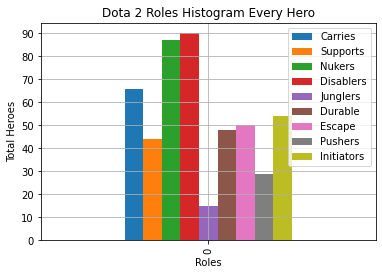

In [191]:
df_hero_roles = pd.DataFrame(np.reshape(np.expand_dims(hero_roles.count(),1),(1,len(hero_roles.columns))),columns=hero_roles.columns)
df_hero_roles.plot(kind="bar",grid="--",yticks=np.arange(0,100,10),title="Dota 2 Roles Histogram Every Hero",ylabel="Total Heroes",xlabel="Roles")
plt.savefig("Figures/Dota_2_Roles_Histogram_Every_Hero.png")
plt.show()

# To Dos

## Finish Preprocess
### All append file and filtering is done BEFORE CALCULATION
### Find a better formula for synergy, right now max is 0.4 and min is -0.1, wtf
### Final formula should be 0 to 1
### What happens if 3 supp or 3 carry, or 3 initiator, etc
### Data scraping hero counters